# Experimentación - STConv


https://arxiv.org/abs/1709.04875

## 1. Obtención de datos



In [1]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload  # Python 3.4+
import torch

import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
results_save_path = "./results"
name_model = "STConv"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [5]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, name, node_features, node_count, n_target, out_channels,k, kernel_size, hidden_channels, normalization="sym"):
        self.name  =name
        self.n_nodes = node_count
        self.n_target = n_target
        self.n_features = node_features
        self.out_channels = out_channels
        self.k = k
        self.kernel_size = kernel_size
        self.normalization = normalization
        self.hidden_channels = hidden_channels
        super(RecurrentGCN, self).__init__()
        self.recurrent = STConv(num_nodes=node_count,
                                in_channels=1,
                                hidden_channels=hidden_channels,
                                out_channels=out_channels,
                                kernel_size=kernel_size,
                                K=k,  # Grado del polinomio Chebyshev
                                normalization=normalization 
                            )

        self.linear = torch.nn.Linear(self.out_channels, self.n_target)


    def forward(self, x, edge_index, edge_weight):

        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = h.squeeze(0).mean(dim=0)
        h = self.linear(h)
        return h

In [6]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable


import torch
import torch.nn.functional as F
from utils.utils_graph import format_plot
from utils.utils_graph import plot_training_and_eval_losses, plot_predictions
from utils.general_nn import guardar_resultados



from utils.trainer import TrainerSTConv
from  utils.stgcn import STConv
from utils.models import STConvModel
#from torch_geometric_temporal.nn import TGCN

## Prueba - predicción por tipos

In [7]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}


num_early_stop = 10
num_epochs = 100
lr = 0.01

### Gen trip

In [8]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [9]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
out_channels = 16
kernel_size = 7
hidden_channels = 32
normalization = "sym"

#### Sencilla 

In [23]:
params =  {"out_channels": out_channels, "kernel_size": kernel_size, "hidden_channels": hidden_channels, "normalization": normalization}

In [17]:
device = torch.device("cpu")
model_gt = RecurrentGCN(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=out_channels,k=2, kernel_size=kernel_size, hidden_channels=hidden_channels, normalization=normalization)

trainer_gt = TrainerSTConv(model_gt, dataset_gt,device, f"../results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=50, steps=200, num_early_stop=num_early_stop)
r2score_tst,losses_tst, loss_nodes, predictions_gt, real_gt= trainer_gt.test()


==================== DATASET INFO ===================

Train dataset: 4352
Validation dataset: 918
Test dataset: 952

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.8032 | Eval Loss: 0.6146 | Eval R2: -294.3996 | LR: 0.0010 | 
Epoch 2/50 | Train Loss: 0.5245 | Eval Loss: 0.4303 | Eval R2: -201.6365 | LR: 0.0010 | 
Epoch 3/50 | Train Loss: 0.3671 | Eval Loss: 0.2825 | Eval R2: -126.7895 | LR: 0.0010 | 
Epoch 4/50 | Train Loss: 0.2396 | Eval Loss: 0.1722 | Eval R2: -72.3006 | LR: 0.0010 | 
Epoch 5/50 | Train Loss: 0.1522 | Eval Loss: 0.1076 | Eval R2: -40.7968 | LR: 0.0010 | 
Epoch 6/50 | Train Loss: 0.1055 | Eval Loss: 0.0764 | Eval R2: -25.4088 | LR: 0.0010 | 
Epoch 7/50 | Train Loss: 0.0810 | Eval Loss: 0.0604 | Eval R2: -17.8418 | LR: 0.0010 | 
Epoch 8/50 | Train Loss: 0.0662 | Eval Loss: 0.0537 | Eval R2: -14.9502 | LR: 0.0010 | 
Epoch 9/50 | Train Loss: 0.0558 | Eval Loss: 0.0484 | Eval R2: -13.1071 | LR: 0.0010 | 
Epoch 10/50 | Train Loss: 0.0474 

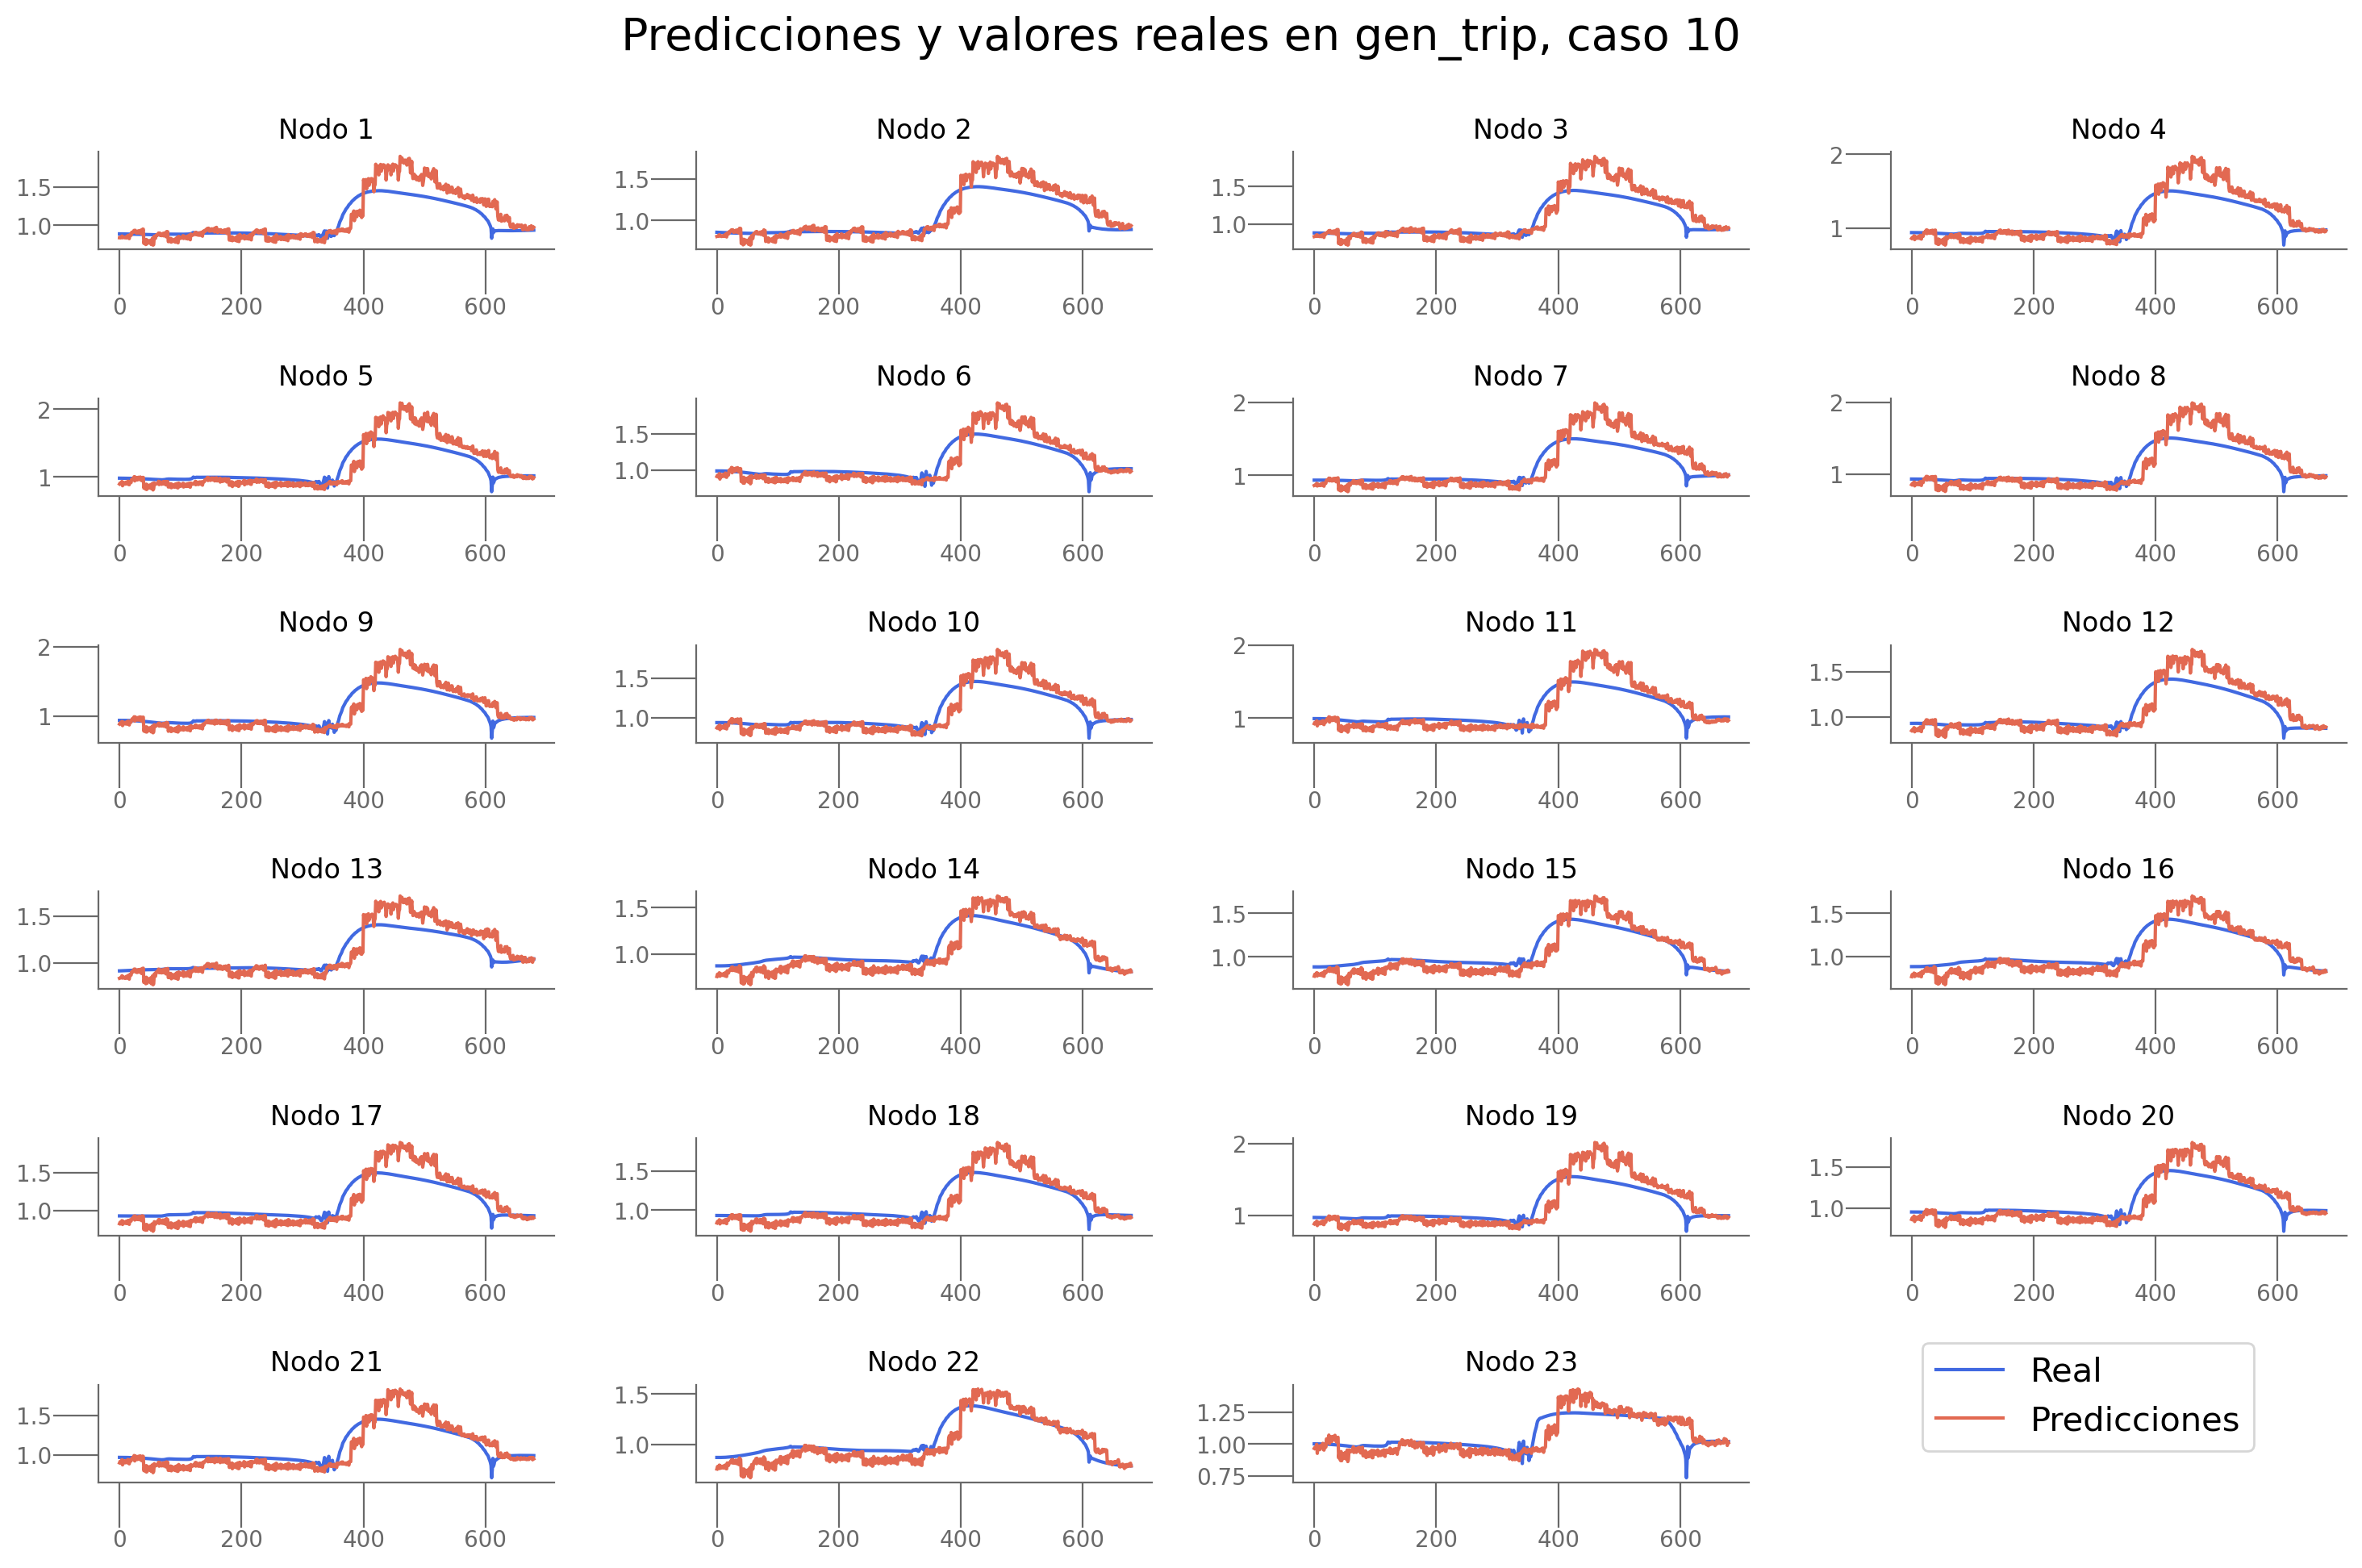

In [18]:
plot_predictions(predictions_gt, real_gt, n_target, 10, n_div_gt, problem_gt)

In [21]:
trainer_gt.save_path = f"./results/{problem_gt}"

In [24]:
trainer_gt.save_model(params=params)


==================== GUARDANDO RESULTADOS ===================

          Modelo                                             Params  \
0           LSTM                                                NaN   
1      MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2   LSTM_NOBATCH                                                NaN   
3    DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4      EvolveGCN                                                NaN   
5         MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6          DCRNN                                     {'hidden': 10}   
7         ASTGCN  {'nb_block': 1, 'K': 2, 'nb_chev_filter': 3, '...   
8         MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
9          MTGNN  {'gcn_depth': 2, 'conv_channels': 16, 'kernel_...   
10         AGCRN             {'hidden': 10, 'K': 2, 'embedding': 3}   
11        STConv               {16: 16, 7: 7, 32: 32, 'sym': 'sym'}   
12        STC

### Bus trip

In [25]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [31]:
n_div_bt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
out_channels = 16
kernel_size = 3
hidden_channels = 32
normalization = "sym"

#### Sencilla 

In [27]:

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model_bt = RecurrentGCN(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=out_channels,k=2, kernel_size=kernel_size, hidden_channels=hidden_channels, normalization=normalization)

trainer_bt = TrainerSTConv(model_bt, dataset_bt,device, f"./results/{problem_bt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=50, steps=200, num_early_stop=10)





==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 1.0523 | Eval Loss: 0.8642 | Eval R2: -26.9927 | LR: 0.0010 | 
Epoch 2/50 | Train Loss: 0.8413 | Eval Loss: 0.7290 | Eval R2: -22.9907 | LR: 0.0010 | 
Epoch 3/50 | Train Loss: 0.7151 | Eval Loss: 0.6255 | Eval R2: -19.4523 | LR: 0.0010 | 
Epoch 4/50 | Train Loss: 0.6150 | Eval Loss: 0.5398 | Eval R2: -16.5391 | LR: 0.0010 | 
Epoch 5/50 | Train Loss: 0.5279 | Eval Loss: 0.4637 | Eval R2: -13.9402 | LR: 0.0010 | 
Epoch 6/50 | Train Loss: 0.4511 | Eval Loss: 0.3963 | Eval R2: -11.6166 | LR: 0.0010 | 
Epoch 7/50 | Train Loss: 0.3836 | Eval Loss: 0.3366 | Eval R2: -9.5482 | LR: 0.0010 | 
Epoch 8/50 | Train Loss: 0.3254 | Eval Loss: 0.2852 | Eval R2: -7.8039 | LR: 0.0010 | 
Epoch 9/50 | Train Loss: 0.2732 | Eval Loss: 0.2327 | Eval R2: -6.1064 | LR: 0.0010 | 
Epoch 10/50 | Train Loss: 0.2246 | Eval

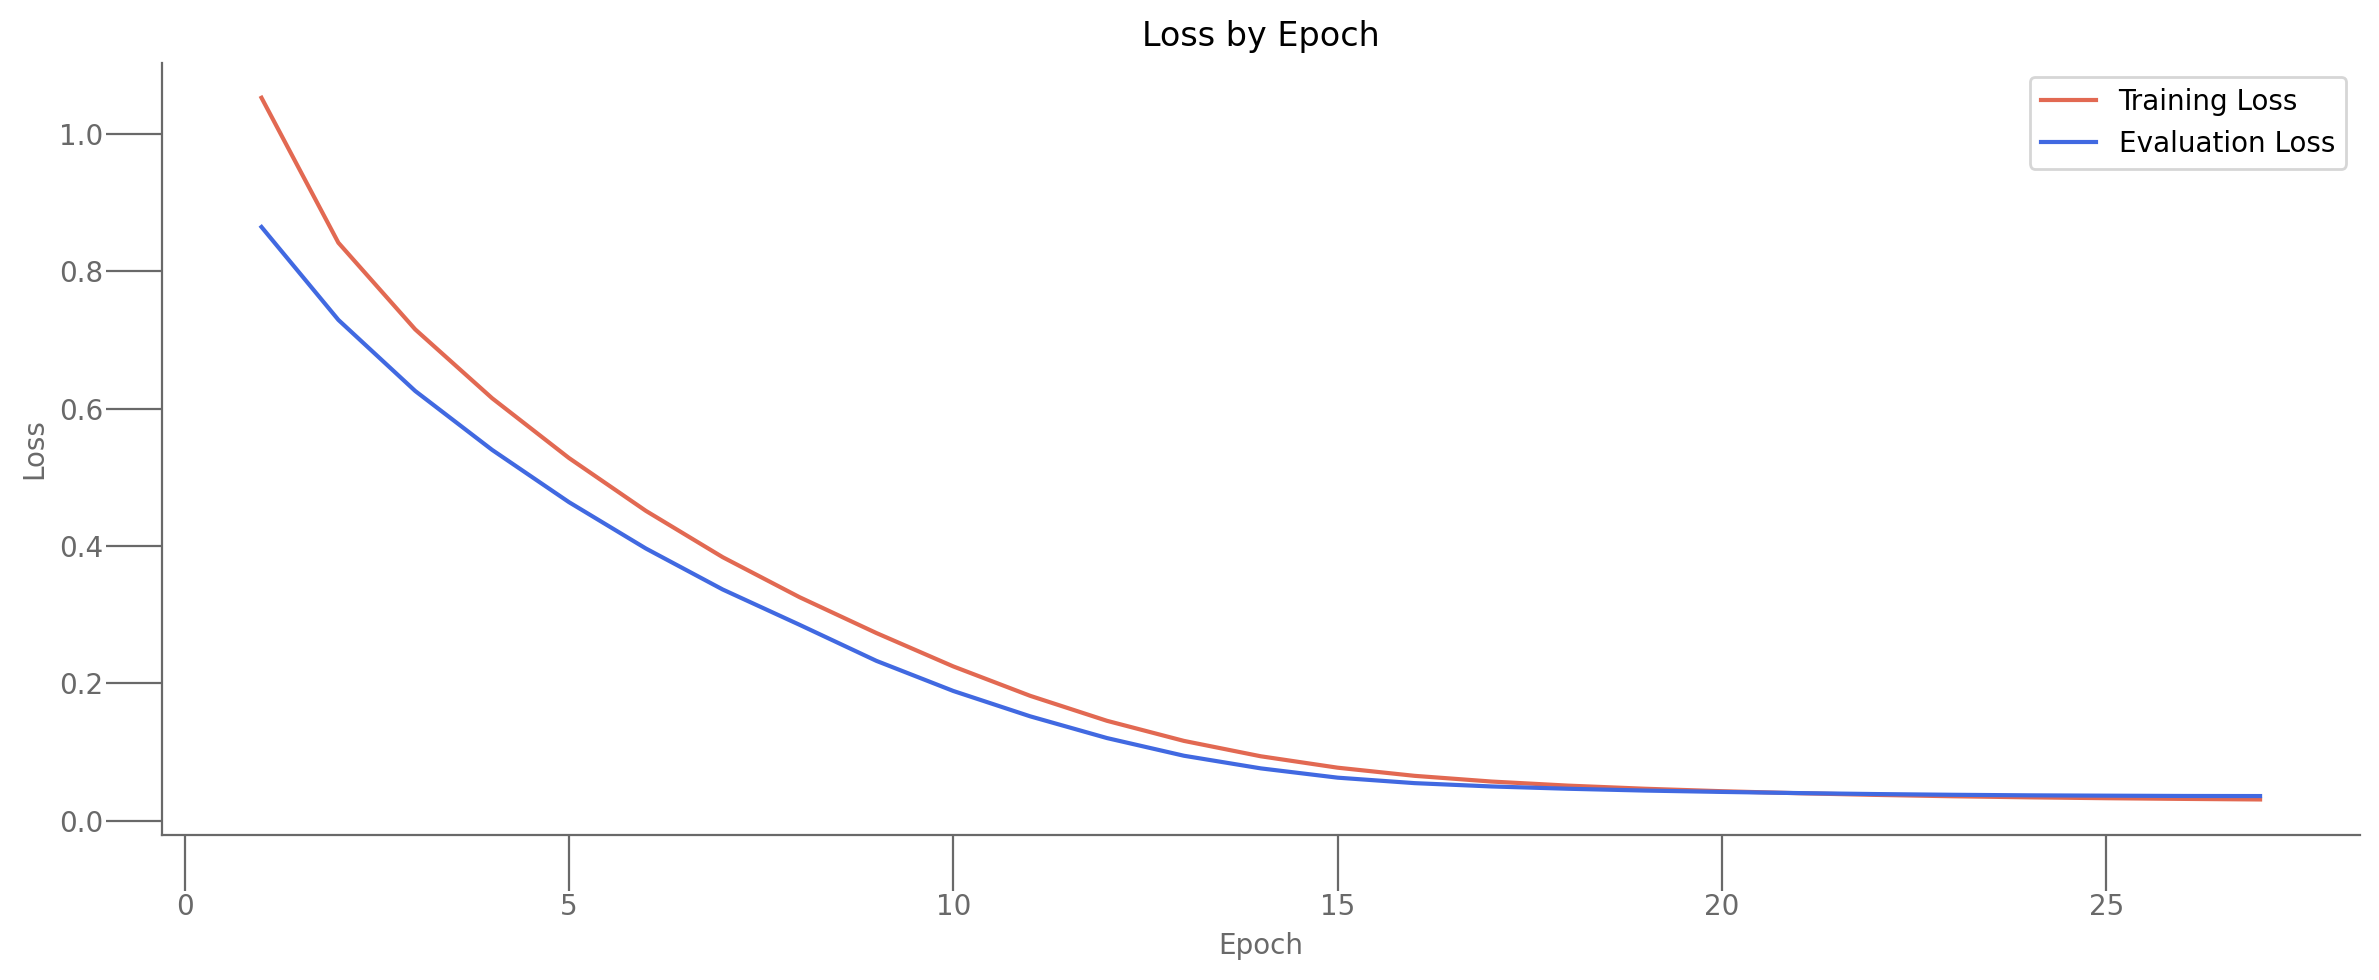


==================== TEST INFO ===================

test loss: 0.040097, test R2 score: 0.146900


In [29]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), len(np.array(losses)), format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = trainer_bt.test()

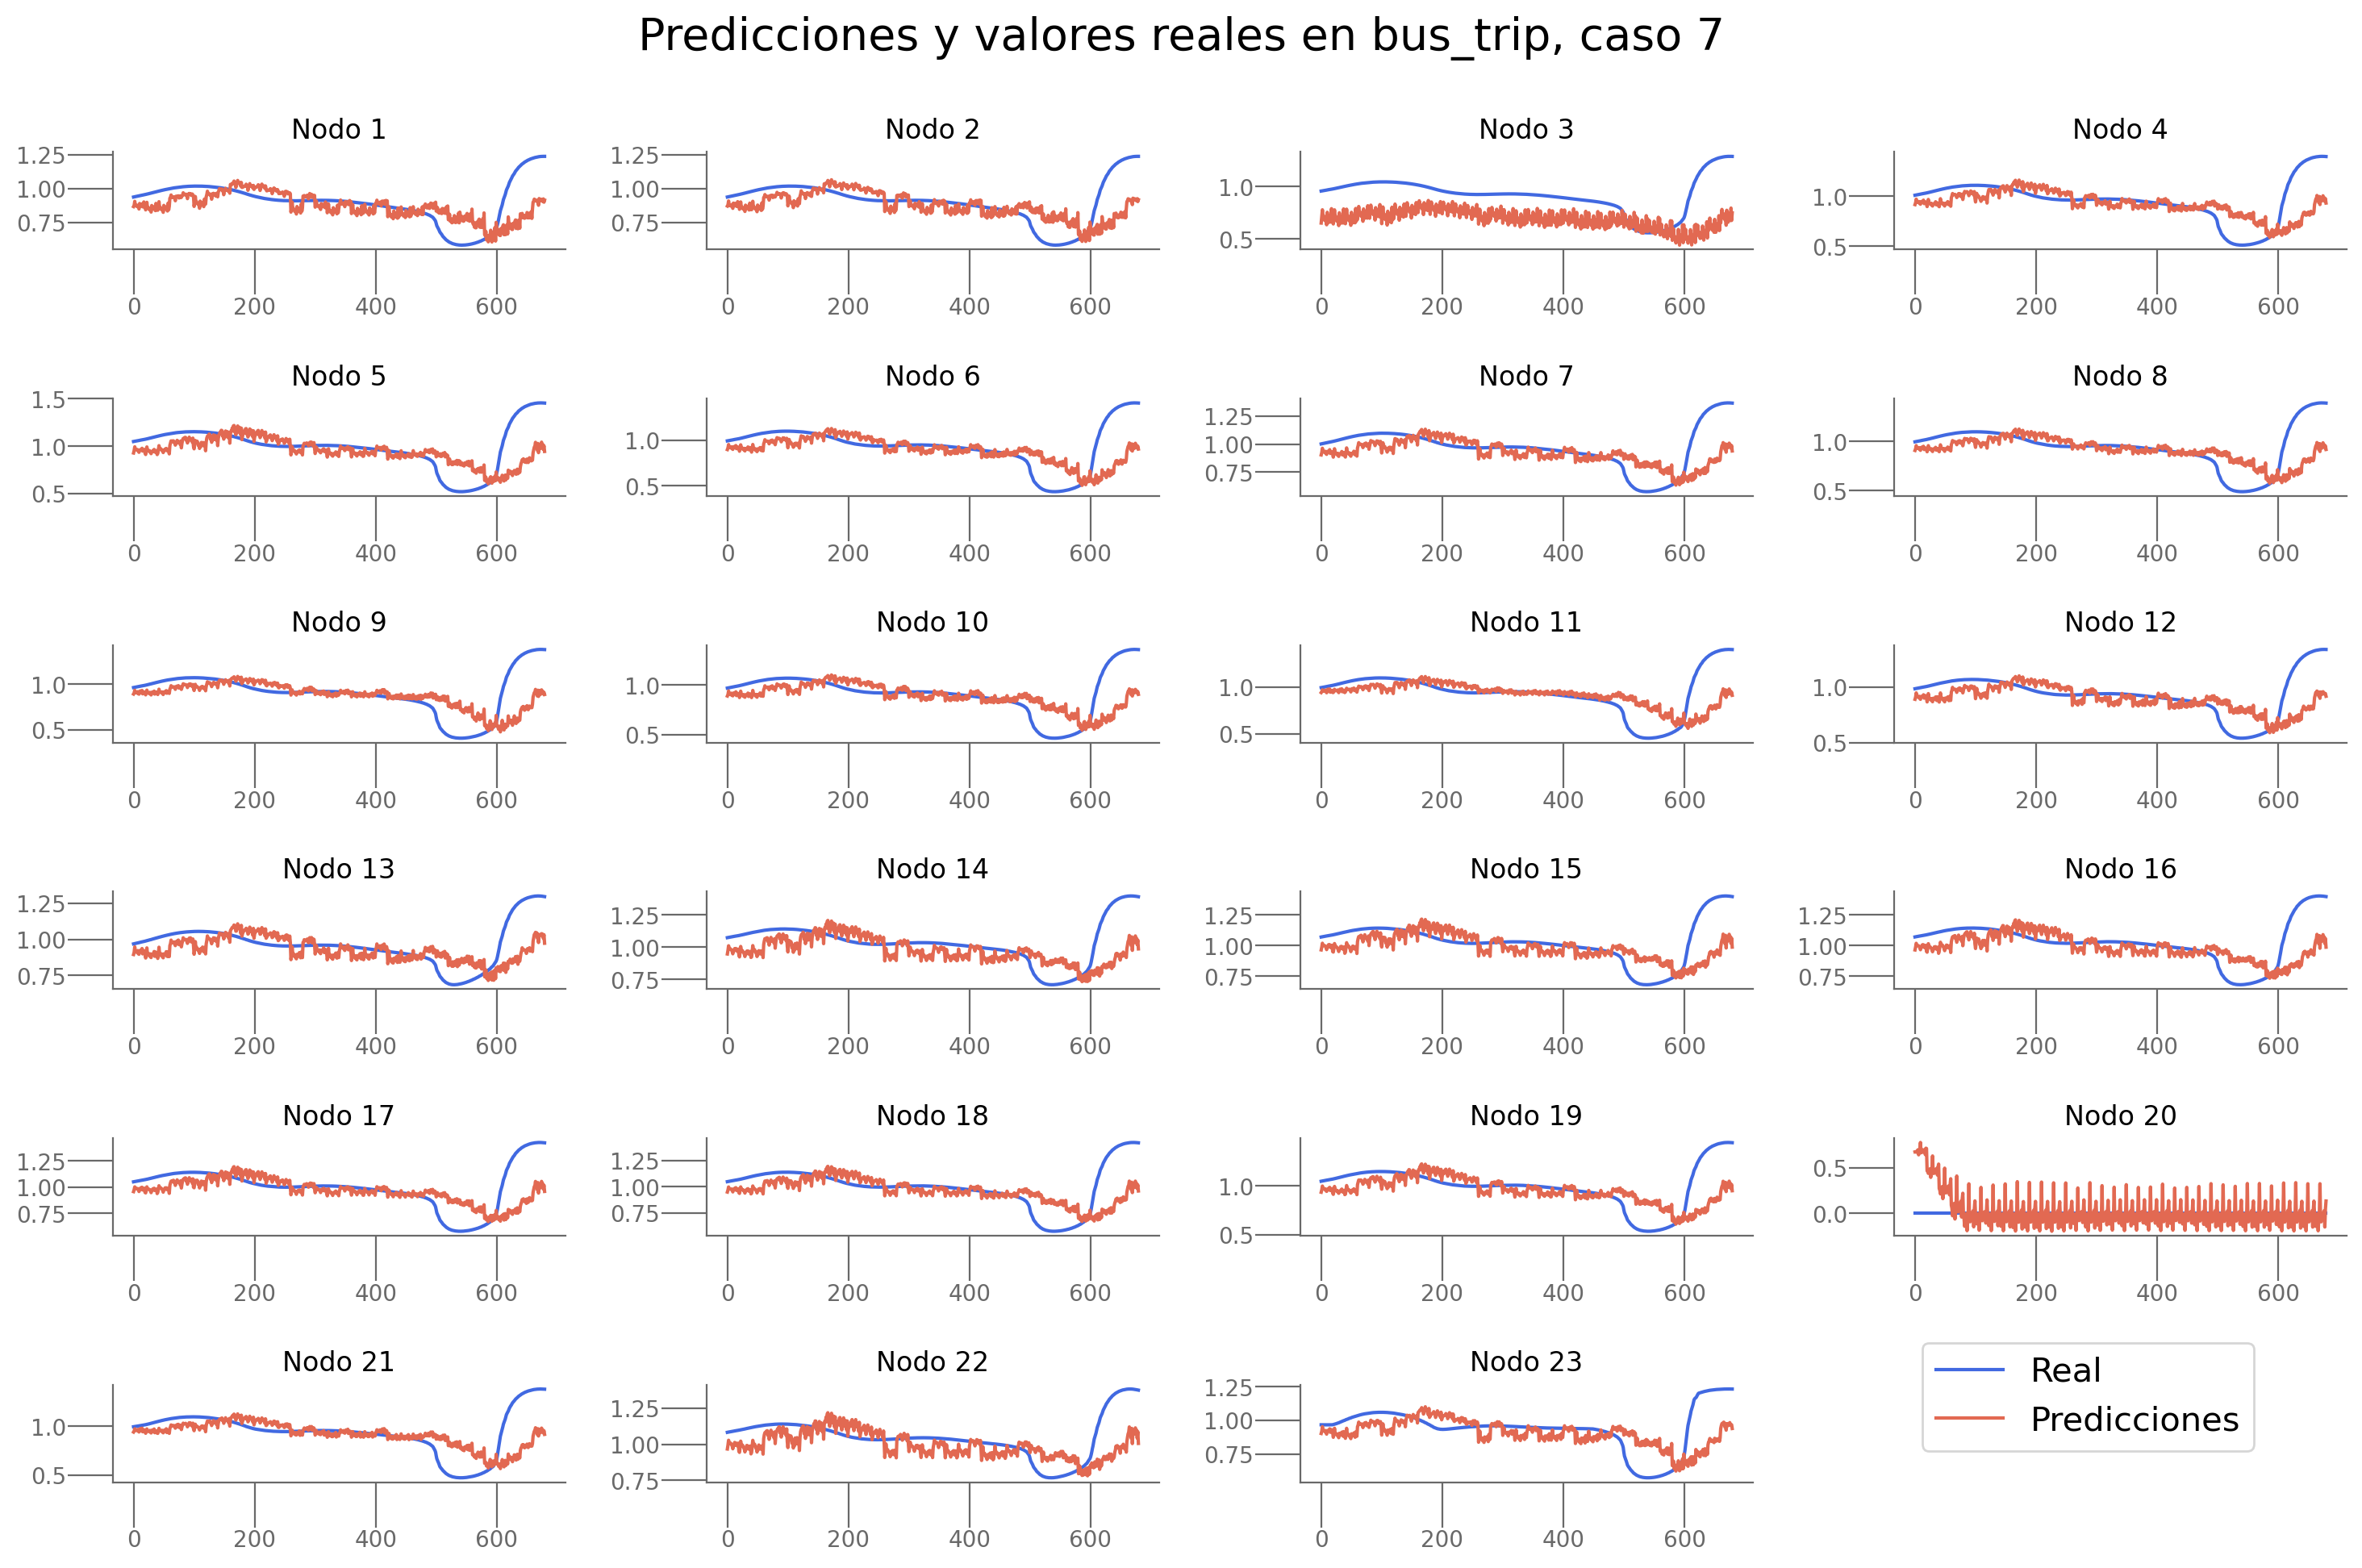

In [32]:
plot_predictions(predictions_bt, real_bt, n_target, 7, n_div_bt, problem_bt)

In [33]:
params =  {"out_channels": out_channels, "kernel_size": kernel_size, "hidden_channels": hidden_channels, "normalization": normalization}
trainer_bt.save_path = f"./results/{problem_bt}"
trainer_bt.save_model(params=params)


==================== GUARDANDO RESULTADOS ===================

          Modelo                                             Params  \
0           LSTM                                                NaN   
1   LSTM_NOBATCH                                                NaN   
2      MPNN_LSTM                {'hidden_size': 32, 'dropout': 0.8}   
3    DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4      EvolveGCN                                                NaN   
5         MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6          DCRNN                                     {'hidden': 60}   
7          MTGNN  {'gcn_depth': 1, 'conv_channels': 16, 'kernel_...   
8         ASTGCN  {'nb_block': 1, 'K': 2, 'nb_chev_filter': 2, '...   
9          AGCRN             {'hidden': 50, 'K': 2, 'embedding': 3}   
10        STConv  {'out_channels': 16, 'kernel_size': 3, 'hidden...   

                       Fichero_resultados_experimento  Loss_tst    R2_tst  \
0     

### Bus fault

In [34]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [46]:
n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
out_channels = 32
kernel_size = 5
hidden_channels = 64
normalization = "sym"

#### Sencilla 

In [37]:

device = torch.device("cpu")
model_bf = RecurrentGCN(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=out_channels,k=2, kernel_size=kernel_size, hidden_channels=hidden_channels, normalization="sym")

trainer_bf = TrainerSTConv(model_bf, dataset_bf,device, f"./results/{problem_bf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bf.train(num_epochs=50, steps=200, num_early_stop=10)




NameError: name 'dataset_bf' is not defined

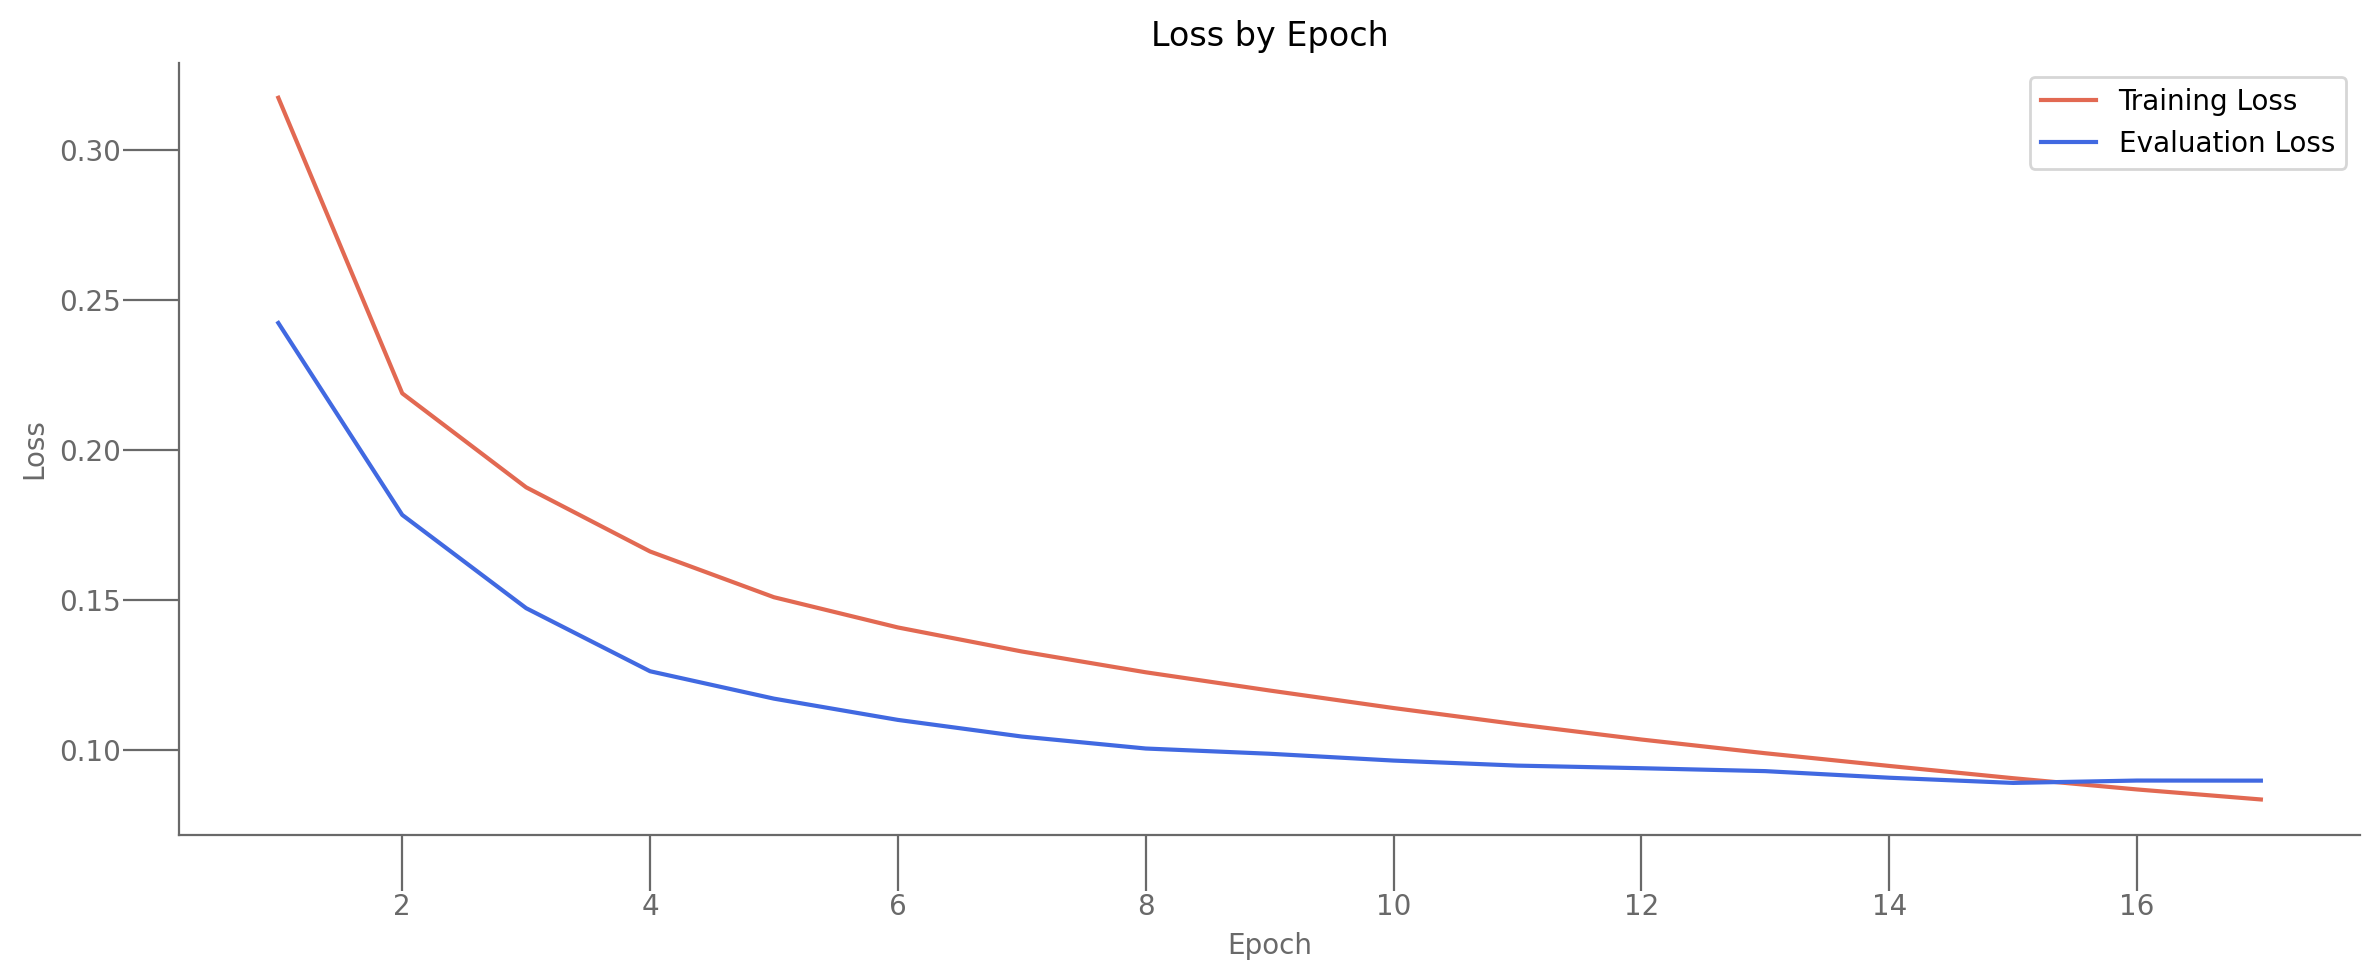

NameError: name 'trainer_bf' is not defined

In [36]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), len(np.array(losses)), format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bf, real_bf = trainer_bf.test()

In [34]:
plot_predictions(predictions_brf, real_brf, n_target, 7, n_div_brf, problem_brf)

NameError: name 'predictions_bf' is not defined

In [51]:
params =  {"out_channels": out_channels, "kernel_size": kernel_size, "hidden_channels": hidden_channels, "normalization": normalization}
trainer_bf.save_path = f"./results/{problem_bf}"
trainer_bf.save_model(params=params)


==================== GUARDANDO RESULTADOS ===================

          Modelo                                             Params  \
0           LSTM                                                NaN   
1   LSTM_NOBATCH                                                NaN   
2      MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
3    DyGrEncoder             {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4         MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
5      EvolveGCN                                                NaN   
6         ASTGCN  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_...   
7          DCRNN                                     {'hidden': 40}   
8          MTGNN  {'gcn_depth': 1, 'conv_channels': 16, 'kernel_...   
9          AGCRN             {'hidden': 10, 'K': 2, 'embedding': 3}   
10        STConv  {'out_channels': 32, 'kernel_size': 5, 'hidden...   
11        STConv  {'out_channels': 32, 'kernel_size': 5, 'hidden...   

            

In [45]:
trainer_bf.model.hidden_channels

16

### Branch Fault

In [20]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [29]:
n_div_bf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
out_channels = 32
kernel_size = 5
hidden_channels = 64
normalization = "sym"

In [41]:
params =  {"out_channels": out_channels, "kernel_size": kernel_size, "hidden_channels": hidden_channels, "normalization": normalization}
params

{'out_channels': 32,
 'kernel_size': 5,
 'hidden_channels': 64,
 'normalization': 'sym'}

#### Sencilla 

In [38]:

device = torch.device("cpu")
model_brf = RecurrentGCN(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=out_channels,k=2, kernel_size=kernel_size, hidden_channels=hidden_channels, normalization="sym")

trainer_brf = TrainerSTConv(model_brf, dataset_brf,device, f"./results/{problem_brf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brf.train(num_epochs=30, steps=400, num_early_stop=10)





==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.5070 | Eval Loss: 0.2582 | Eval R2: -27.0559 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.2266 | Eval Loss: 0.1498 | Eval R2: -15.0477 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1875 | Eval Loss: 0.1201 | Eval R2: -11.6291 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1640 | Eval Loss: 0.1009 | Eval R2: -9.8823 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1452 | Eval Loss: 0.0960 | Eval R2: -9.6110 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1320 | Eval Loss: 0.0969 | Eval R2: -10.1231 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1214 | Eval Loss: 0.1049 | Eval R2: -11.5453 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1127 | Eval Loss: 0.1007 | Eval R2: -11.0971 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1049 | Eval Loss: 0.0990 | Eval R2: -10.9780 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0.0987 | Eva

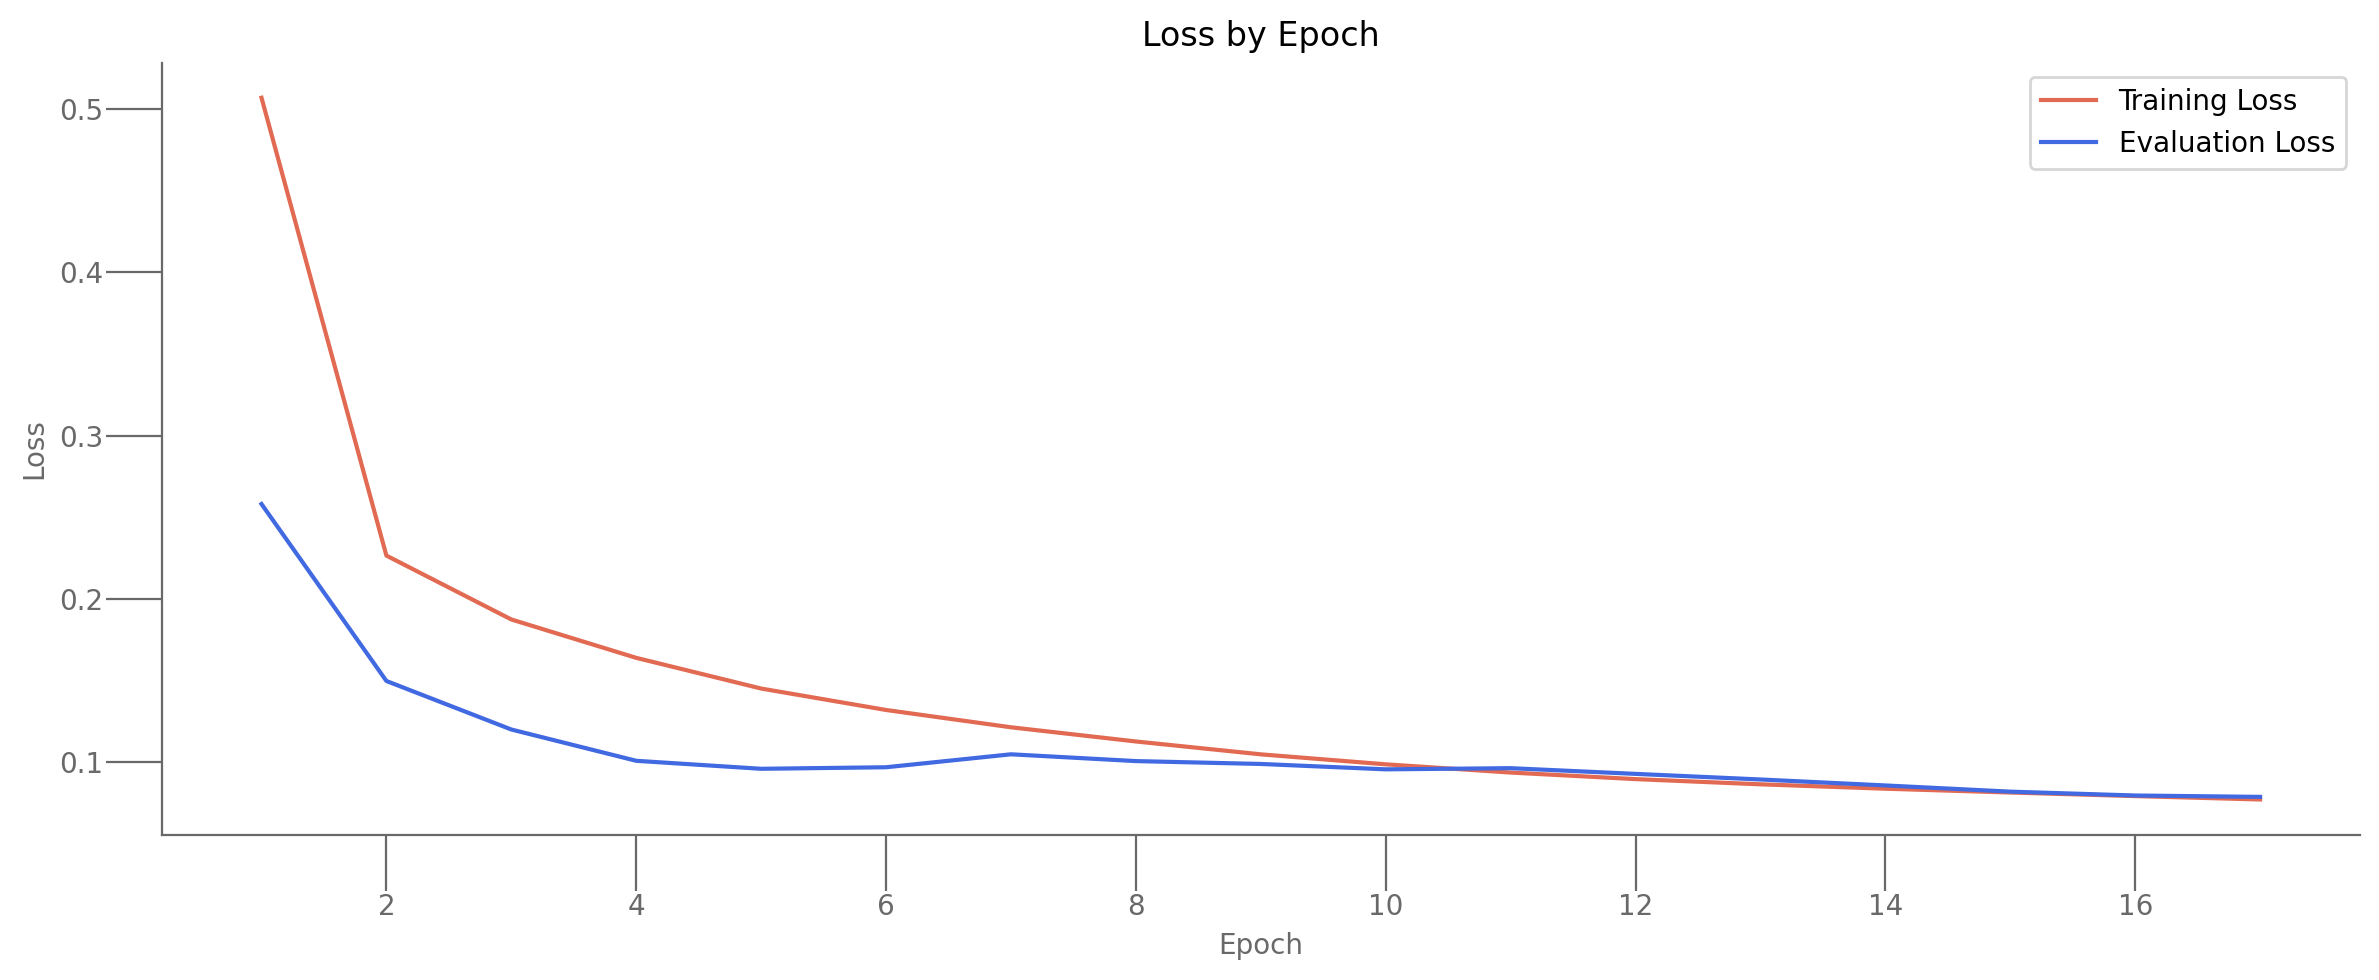


==================== TEST INFO ===================

test loss: 0.061407, test R2 score: -5.958454


In [39]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), len(np.array(losses)), format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brf, real_brf = trainer_brf.test()

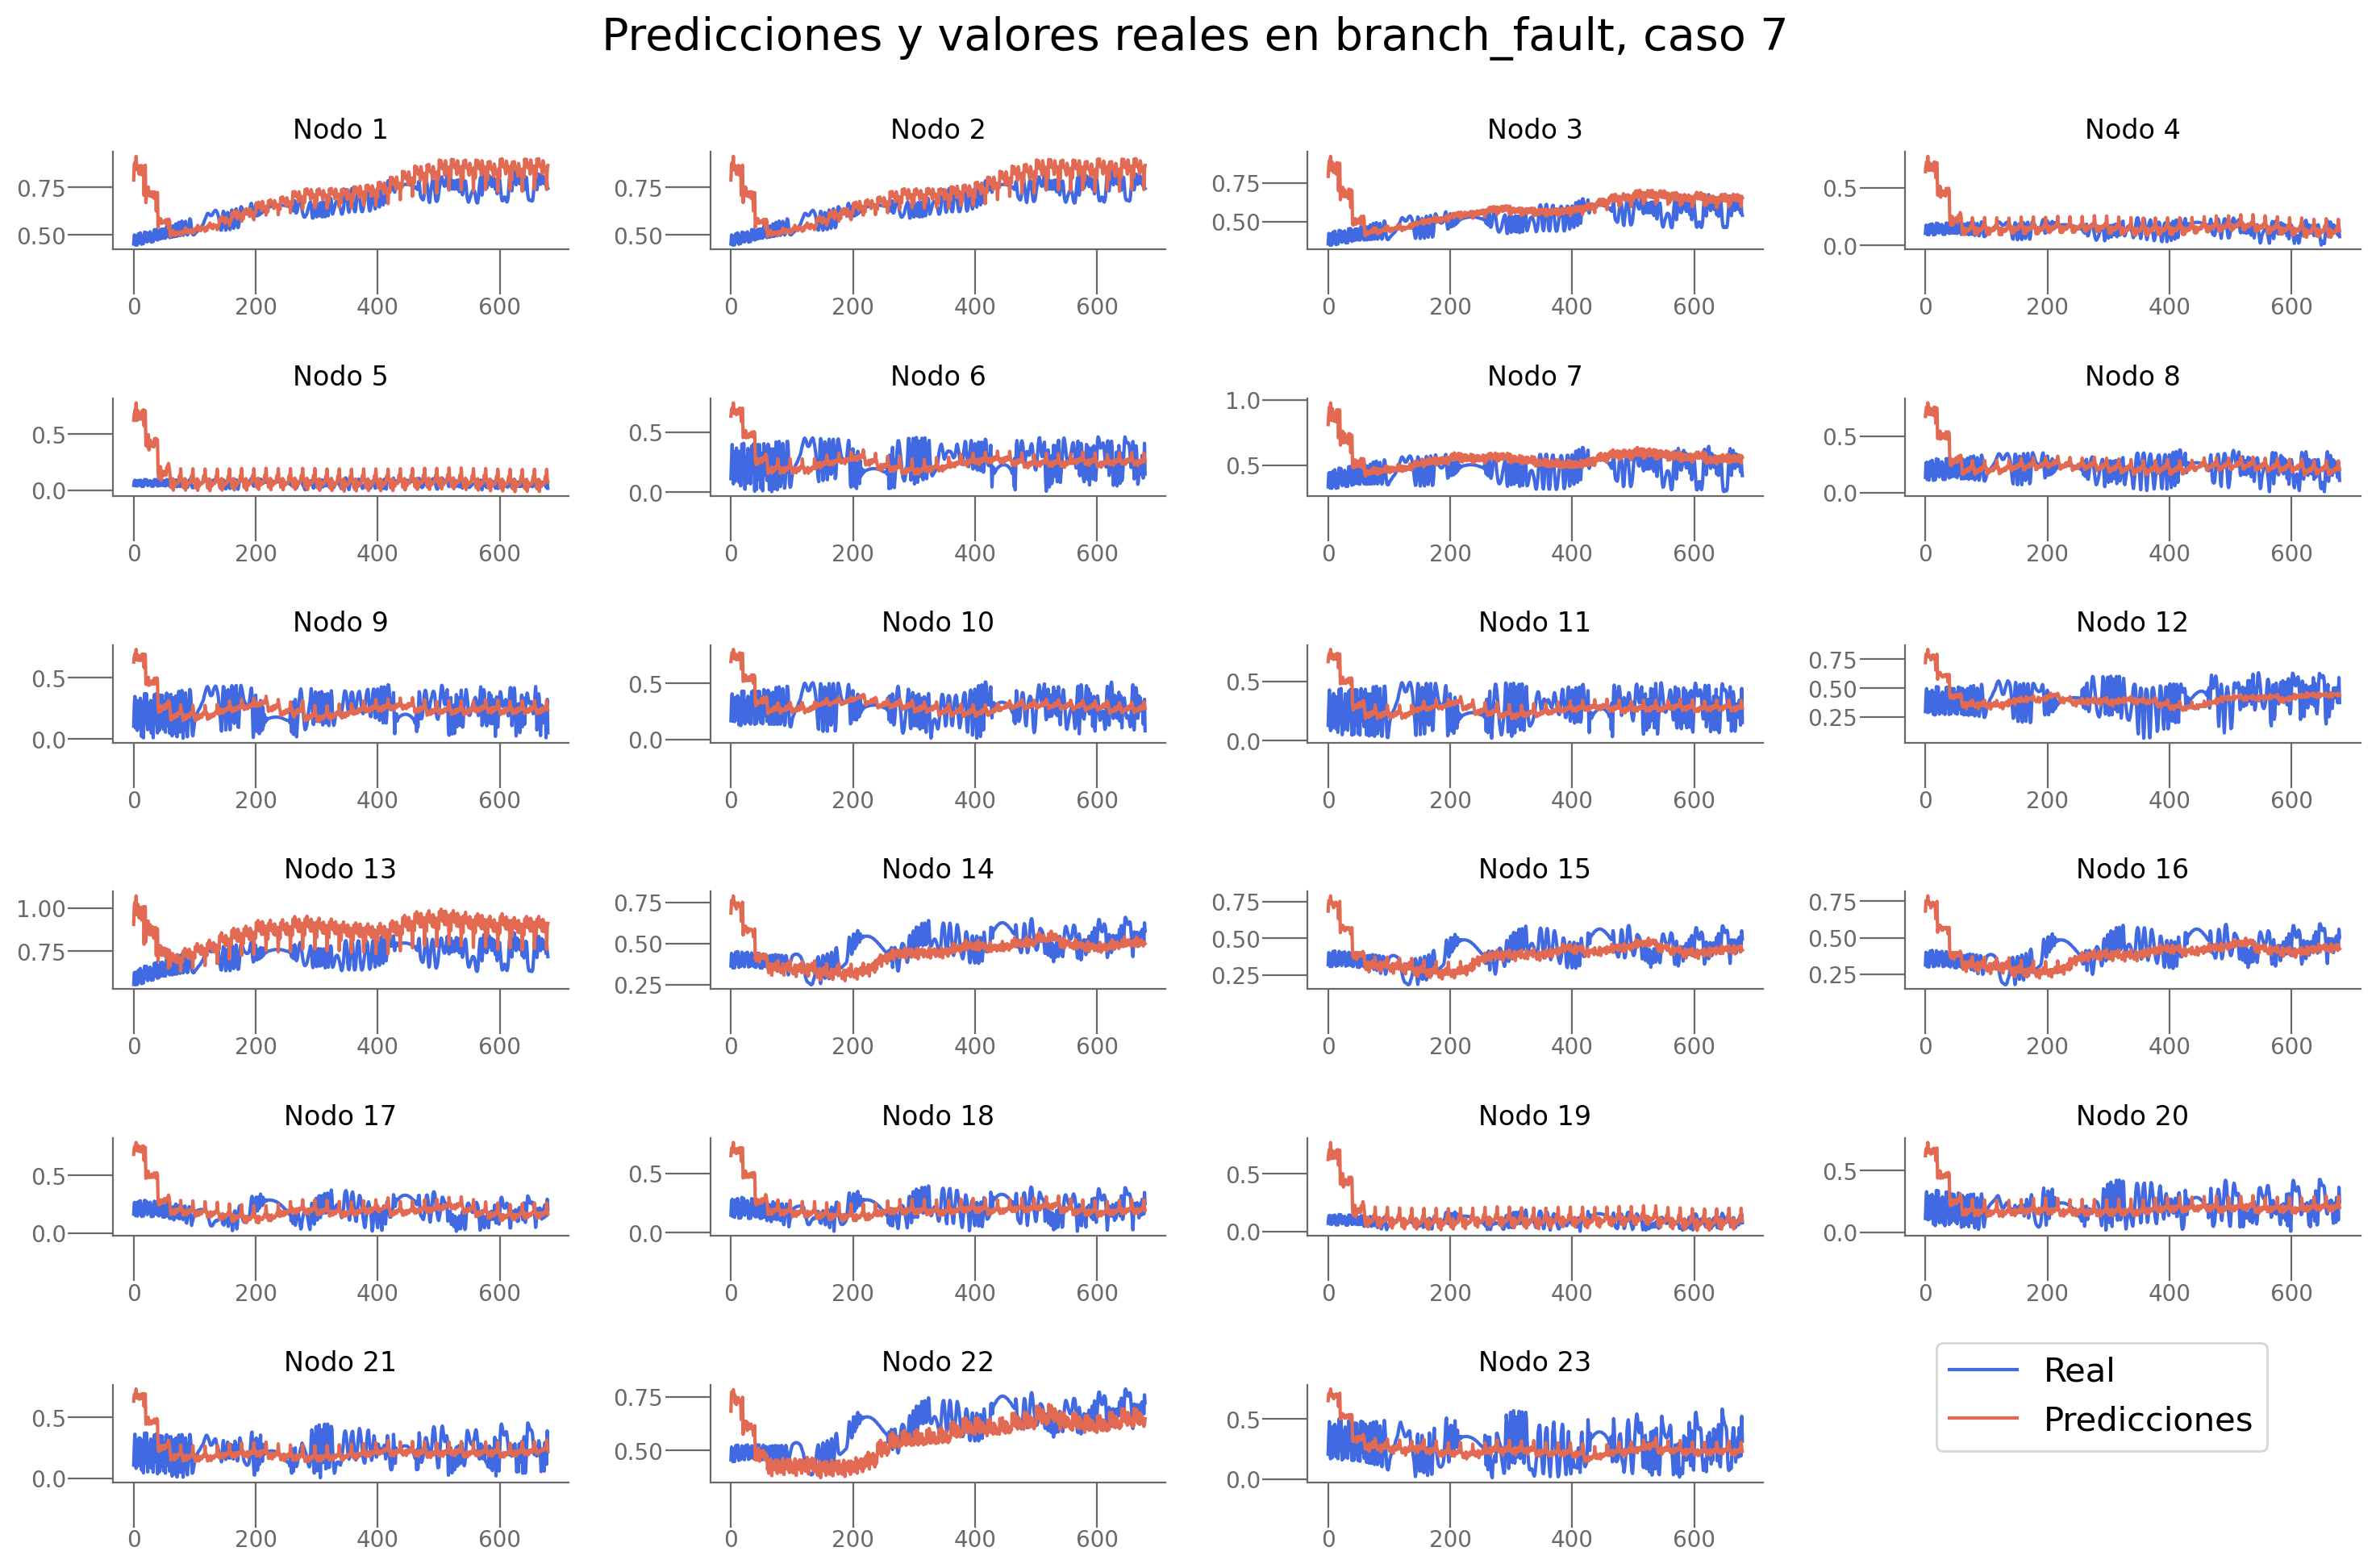

In [40]:
plot_predictions(predictions_brf, real_brf, n_target, 7, n_div_bf, problem_brf)

In [43]:
trainer_brf.save_path = f"./results/{problem_brf}"
trainer_brf.save_model(params=params)


==================== GUARDANDO RESULTADOS ===================

          Modelo                                             Params  \
0           LSTM                                                NaN   
1   LSTM_NOBATCH                                                NaN   
2    DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3      MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
4         MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
5      EvolveGCN                                                NaN   
6         ASTGCN  {'nb_block': 1, 'K': 2, 'nb_chev_filter': 4, '...   
7          DCRNN                                     {'hidden': 60}   
8          MTGNN  {'gcn_depth': 2, 'conv_channels': 16, 'kernel_...   
9          AGCRN             {'hidden': 10, 'K': 2, 'embedding': 3}   
10        STConv  {'out_channels': 32, 'kernel_size': 5, 'hidden...   

                       Fichero_resultados_experimento  Loss_tst     R2_tst  \
0    

### Branch trip

In [8]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [16]:
n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
out_channels = 32
kernel_size = 5
hidden_channels = 64
normalization = "sym"

#### Sencilla 

In [18]:

device =  torch.device("cpu")
model_brt = RecurrentGCN(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=out_channels,k=2, kernel_size=kernel_size, hidden_channels=hidden_channels, normalization=normalization)

trainer_brt = TrainerSTConv(model_brt, dataset_brt,device, f"./results/{problem_brt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brt.train(num_epochs=50, steps=400, num_early_stop=10)





==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.5902 | Eval Loss: 0.3593 | Eval R2: -295.7302 | LR: 0.0010 | 
Epoch 2/50 | Train Loss: 0.3573 | Eval Loss: 0.3069 | Eval R2: -251.3331 | LR: 0.0010 | 
Epoch 3/50 | Train Loss: 0.2971 | Eval Loss: 0.2443 | Eval R2: -197.8317 | LR: 0.0010 | 
Epoch 4/50 | Train Loss: 0.2343 | Eval Loss: 0.1942 | Eval R2: -155.2177 | LR: 0.0010 | 
Epoch 5/50 | Train Loss: 0.1887 | Eval Loss: 0.1592 | Eval R2: -125.3769 | LR: 0.0010 | 
Epoch 6/50 | Train Loss: 0.1522 | Eval Loss: 0.1272 | Eval R2: -98.1619 | LR: 0.0010 | 
Epoch 7/50 | Train Loss: 0.1225 | Eval Loss: 0.1024 | Eval R2: -76.7610 | LR: 0.0010 | 
Epoch 8/50 | Train Loss: 0.1001 | Eval Loss: 0.0844 | Eval R2: -61.2118 | LR: 0.0010 | 
Epoch 9/50 | Train Loss: 0.0828 | Eval Loss: 0.0704 | Eval R2: -49.0430 | LR: 0.0010 | 
Epoch 10/50 | Train Loss: 0.069

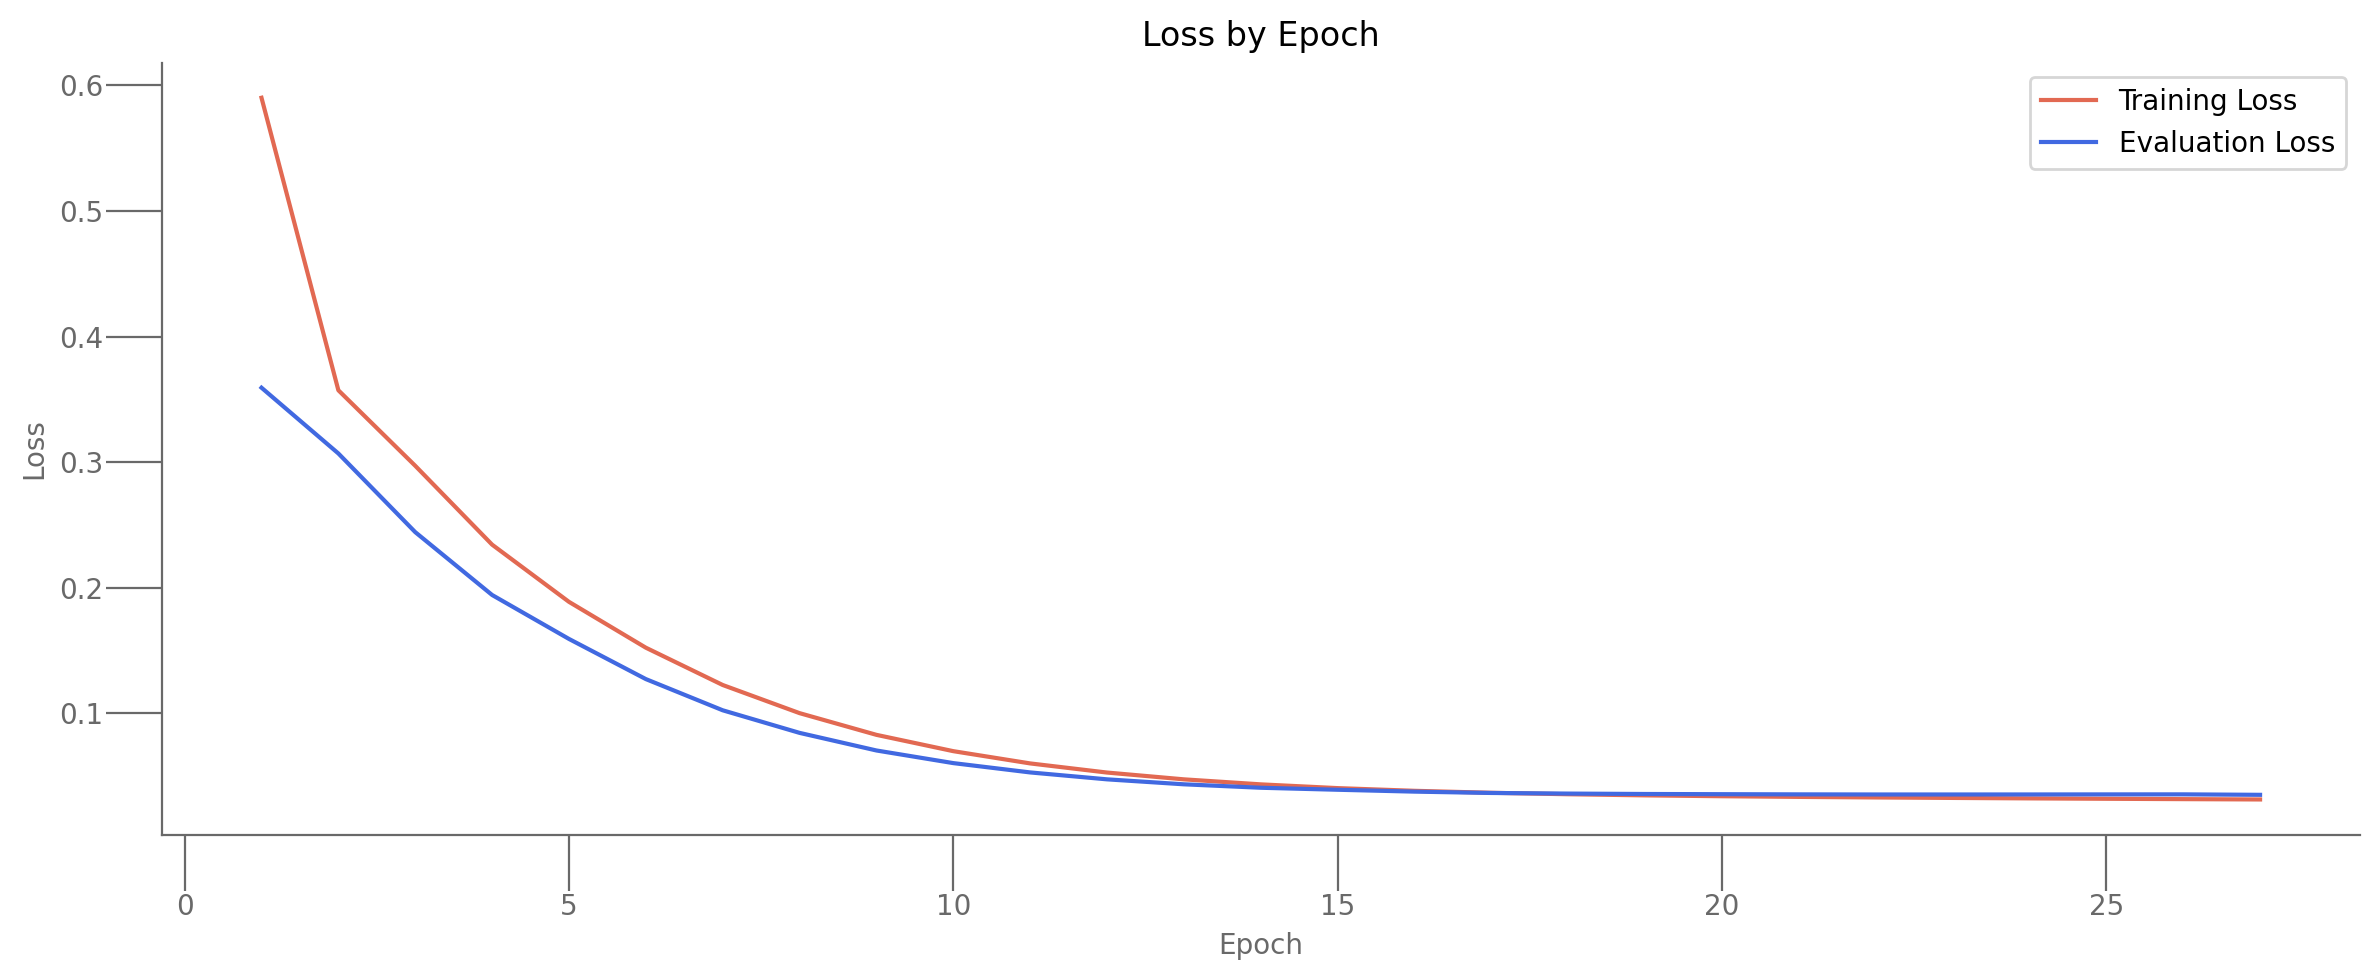


==================== TEST INFO ===================

test loss: 0.036503, test R2 score: -18.098037


In [19]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), len(np.array(losses)), format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brt, real_brt = trainer_brt.test()

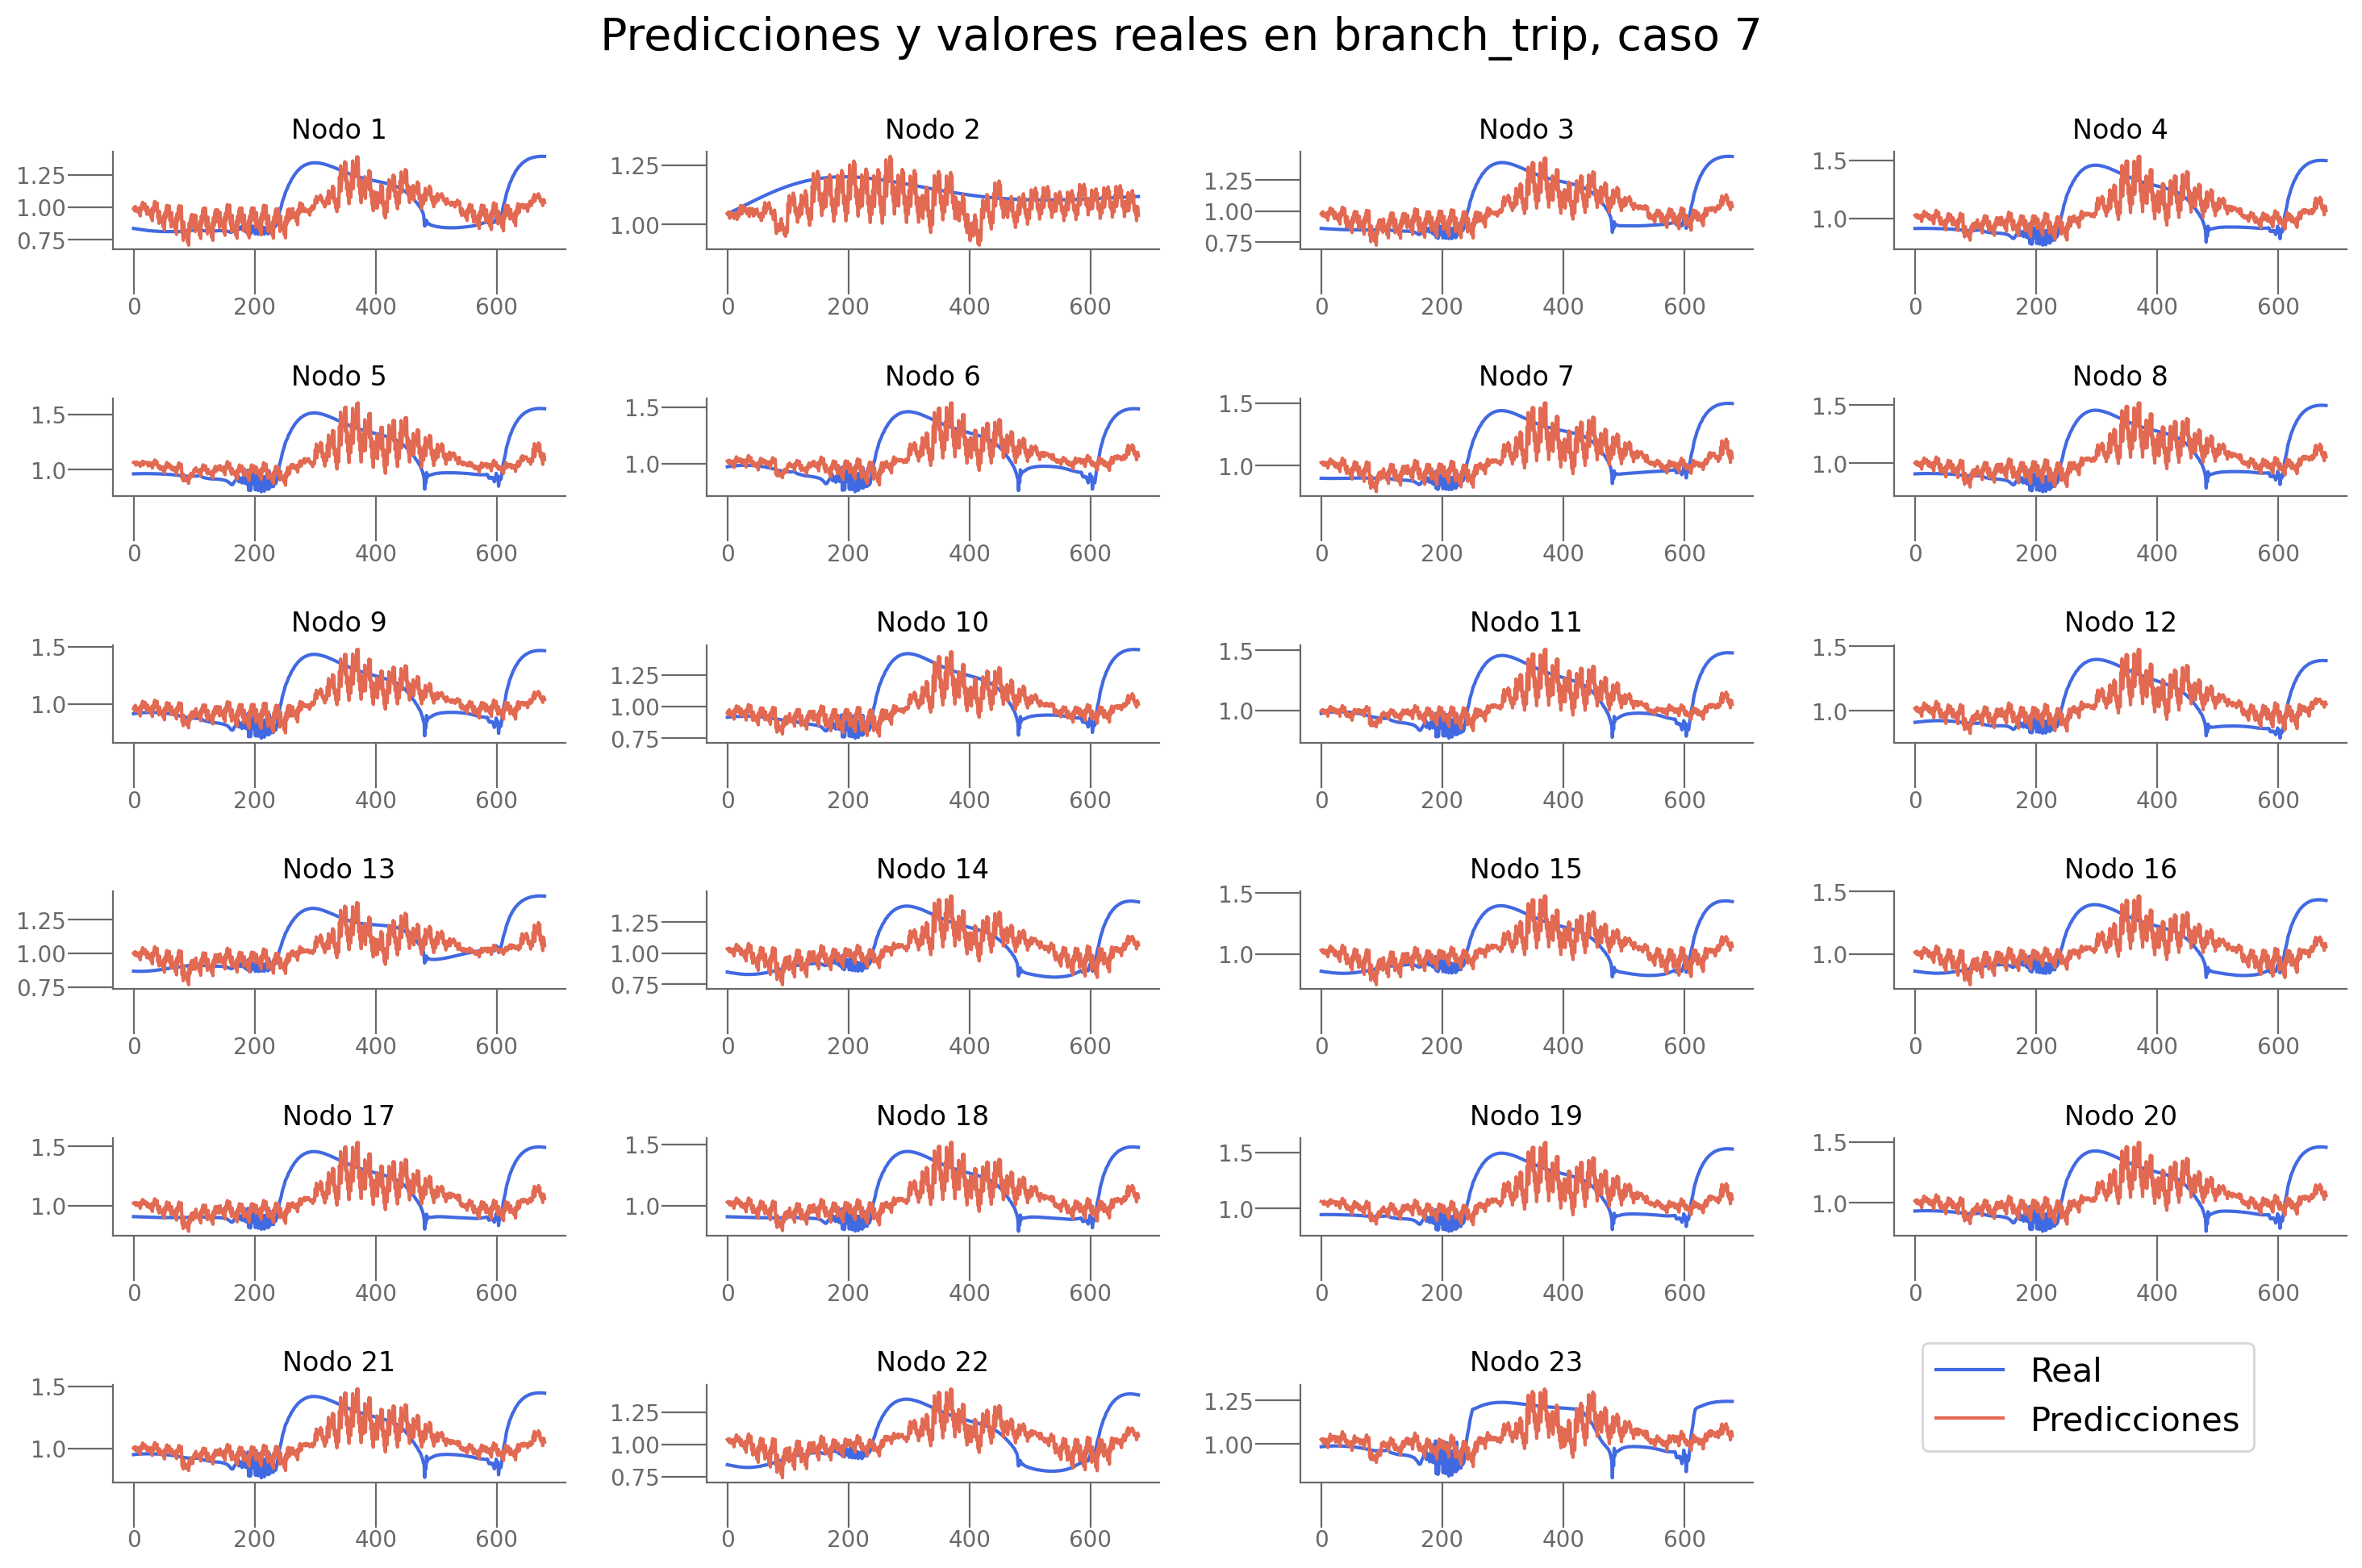

In [20]:
plot_predictions(predictions_brt, real_brt, n_target, 7, n_div_brt, problem_brt)

In [21]:
params =  {"out_channels": out_channels, "kernel_size": kernel_size, "hidden_channels": hidden_channels, "normalization": normalization}
params

{'out_channels': 32,
 'kernel_size': 5,
 'hidden_channels': 64,
 'normalization': 'sym'}

In [22]:
trainer_brt.save_path = f"./results/{problem_brt}"
trainer_brt.save_model(params=params)


==================== GUARDANDO RESULTADOS ===================

          Modelo                                             Params  \
0           LSTM                                                NaN   
1   LSTM_NOBATCH                                                NaN   
2    DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3      MPNN_LSTM                {'hidden_size': 32, 'dropout': 0.8}   
4         MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
5      EvolveGCN                                                NaN   
6         ASTGCN  {'nb_block': 1, 'K': 2, 'nb_chev_filter': 4, '...   
7          DCRNN                                     {'hidden': 60}   
8          MTGNN  {'gcn_depth': 2, 'conv_channels': 8, 'kernel_s...   
9          AGCRN             {'hidden': 10, 'K': 2, 'embedding': 3}   
10        STConv  {'out_channels': 32, 'kernel_size': 5, 'hidden...   

                       Fichero_resultados_experimento  Loss_tst     R2_tst  \
0    